In [1]:
import sys
import numpy as np
import numpy.matlib
import numpy.random
import matplotlib.pyplot as plt
import os
import cv2
import time

import scipy.io
import skimage
import imageio
import colour as c
import math
import csv
import pandas as pd
import heapq

from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import axes3d 
from scipy import ndimage
from scipy import misc
from scipy import fftpack
from scipy import optimize
from fnmatch import fnmatch
from datetime import datetime



## Linear to sRGB
def lin2srgb (x):
    result = (x <= 0.0031308) * np.multiply(x,12.92) + (x > 0.0031308) * np.subtract(np.multiply(1.055,np.power(x,(1/2.4))),0.055)
    return result


## sRGB to Linear 
def srgb2lin (x):
    result = (x <= 0.04045) * np.divide(x,12.92) + (x > 0.04045) * np.power(np.divide(np.add(x,0.055),1.055),2.4)
    return result

# SDR Formulas

## Input Luminance between 0-1
## Output Videosignal
def oetf709(x): 
    return np.subtract(np.multiply(np.power(x, 0.45), 1.099), 0.099)*(0.018<= x) + np.multiply(4.5, x) * (x <0.018)

def eotf1886(x, Lw = 100, Lb = 0): 
    gamma = 2.4
    a = np.power(np.subtract(np.power(Lw, np.divide(1,gamma)),np.power(Lb, np.divide(1, gamma))), gamma)
    b = np.divide(np.power(Lb, np.divide(1,gamma)) , np.subtract(np.power(Lw , np.divide(1,gamma)), np.power( Lb , np.divide(1, gamma))))
    return np.multiply(a , np.power( np.maximum(np.add(x, b), 0) , gamma))

def eotf1886_CRT(x, Lw = 100, Lb = 0, b = 0): 
    Vc = 0.35
    a1 = 2.6
    a2 = 3.0
    k = np.subtract(Lw,np.power(np.add(1,b),a1))
    return (x < Vc) * np.multiply(np.multiply(k,np.power(np.add(Vc,b),np.subtract(a1,a2))),np.power(np.add(x,b),a2)) + (Vc <= x) * np.multiply(k,np.power(np.add(x,b),a1))

## Luma Formulas for Rec2020 / Rec709 -> Fixed Addition
def luma709(img): 
    return np.multiply(img[:,:,0],0.2126) + np.multiply(img[:,:,1],0.7152) + np.multiply(img[:,:,2],0.0722)
def luma2020(img): 
    return np.multiply(img[:,:,0],0.2627) + np.multiply(img[:,:,1],0.6780) + np.multiply(img[:,:,2],0.0593)

## Formulas for PQ

# increasing rec.709 formulas 
def steroids709(x): 
    return np.subtract(np.multiply(np.power(np.multiply(59.5208 , x), 0.45), 1.099), 0.099)*(0.0003024< x) + np.multiply(267.84, x) * (x <= 0.0003024)

def steroids1886(x): 
    return np.multiply(100, np.power(x, 2.4))


## Transportfunctions

def pq_eotf(x): 
    ##m1
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    
    return np.multiply(np.power(np.divide(np.maximum( np.subtract( np.power(x , np.divide(1 , m2)), c1) , 0) , np.subtract(c2, np.multiply(c3 , np.power(x , np.divide(1 , m2))))) , np.divide(1, m1)), 10000)

## Inverse_eotf

def pq_eotf_inv(x): 
    m1 = np.divide(2610, 16384) ## 2^14 = 16384
    m2 = np.multiply(np.divide(2523, 4096), 128) ##2^12 = 4096 , 2^7 = 128 -> Jan fragen
    c1 = np.divide(3424, 4096)
    c2 = np.multiply(np.divide(2413, 4096), 32)
    c3 = np.multiply(np.divide(2392, 4096), 32)

    y = np.divide(x , 10000) ## Normalisierung auf 0.00 bis 1.0

    return np.power( np.divide(np.add(c1 , np.multiply(c2 , np.power(y , m1))), np.add(1 , np.multiply(c3 , np.power(y , m1)))), m2)

# RGB Input
def hlg_oetf(x): 
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))

    return np.where(x <= np.divide(1,12), np.sqrt(np.multiply(3,x )), np.add( np.multiply(a , np.log(np.subtract( np.multiply(12 , x ), b))) , c) )

def hlg_oetf_inv(x):
    a = 0.17883277
    b = np.subtract(1 , np.multiply(4 , a))
    c = np.subtract(0.5 , np.multiply(a , np.log(np.multiply(4 , a))))
    
    return np.where(x <= 0.5 , np.divide( np.power(x,2), 3), np.divide(np.add(np.exp(np.divide(np.subtract(x , c), a)), b) , 12) )

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf(x, Lw): 
    r = x[: , : , 0]
    g = x[: , : , 1]
    b = x[: , : , 2]
    luma = np.add(np.multiply(0.2627 ,r ), np.multiply(0.678 , g), np.multiply(0.0593 , b))
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    rd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), r)
    gd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), g)
    bd = np.multiply( alpha , np.power(luma , np.subtract(gamma , 1)), b)
    return np.stack((rd , gd , bd))

## Lw = Usergain, nominal peak Luminance of the display (achromatic)
def hlg_ootf_bw(x, Lw=1000): 
    alpha = Lw
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    return np.multiply(np.multiply( alpha , np.power(x , np.subtract(gamma , 1))),x)

def hlg_eotf(x, Lw = 1000, Lb = 0.005):
    gamma = np.add(1.2, np.multiply(0.42 , np.log10(np.divide(Lw,1000))))
    beta = np.sqrt(np.multiply(3 , np.power(np.divide(Lb , Lw), np.divide(1,gamma))))
    return hlg_ootf_bw(hlg_oetf_inv(np.maximum(0 , (np.add( np.multiply( np.subtract(1 , beta), x ), beta)))), Lw)


def slog3oetf(x): 
    # reflection add
    x = x*0.9

    return (x < 0.01125)* np.divide( np.add( np.multiply(x , np.divide(np.subtract(171.2102946929, 95), 0.01125)), 95), 1023) + (x >= 0.01125)* np.divide(np.add(420 , np.multiply( np.log10(np.divide(np.add(x,0.01), np.add(0.18, 0.01))), 261.5)), 1023)

def slog3eotf(x): 
    return (x >= np.divide(171.2102946929,1023)) * np.subtract( np.multiply(np.power(10 , np.divide( np.subtract(420 , np.multiply(x , 1023)) , 261.5)) , np.add(0.18 , 0.01)) , 0.01) + (x < np.divide(171.2102946929,1023)) * np.multiply(np.subtract(np.multiply(x , 1023), 95 ) , np.divide(0.01125 , np.subtract(171.2102946929 , 95)))

# These are the ARRI LogCv3 Formulas
def lin2logc(x):
    return np.multiply(x > 0.010591, 0.24719 * np.log10(5.555556 * x + 0.052272) + 0.385537) + np.multiply(x <= 0.010591, 5.367655 * x + 0.092809)
def logc2lin(x):
    return np.multiply(x > 0.149659, (np.power(10.0, (x - 0.385537) / 0.247189) - 0.052272) / 5.555556) + np.multiply(x <= 0.149659, (x - 0.092809) / 5.367650)


### LOG C4
def Encoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < t) * np.divide(np.subtract(x,t),s) + (x >= t) * np.add(np.multiply(np.divide( np.subtract(np.log2(np.add(np.multiply(a,x),64.0)),6.0),14.0),b),c)

def Decoding_LogC4(x):
    a = (np.power(2.0, 18.0) - 16.0) / 117.45
    b = (1023.0 - 95.0) / 1023.0
    c = 95.0 / 1023.0
    s = (7 * np.log(2) * np.power(2.0, 7 - 14 * c / b)) / (a * b)
    t = (np.power(2.0, 14.0 * (-c / b) + 6.0) - 64.0) / a
    return (x < 0.0) * np.add(np.multiply(x,s),t) + (x >= 0.0) * np.divide(np.subtract(np.power(2.0, np.add(np.multiply(14,np.divide(np.subtract(x,c),b)),6)),64.0),a)


def full2legal(x):
    return (219*(x)+16)*np.power(2,(10-8))

def legal2full(x):
    return (((x/np.power(2,(10-8)))-16)/219)

def lin2log2(x):
    return np.log2(x)

def log22lin(x):
    return np.power(2,x)

def Blenden_Differenz(num1, num2):
    new2 = num2 / num1
    return np.log2(new2)

def mse_calculation(imageA, imageB):
    # Expects Luma Images
	err = np.mean(np.square(np.subtract(imageA,imageB)))
	return err

def BT2020_Linear_to_ICtCp(original):
    ictcp_array = np.zeros((np.shape(original)))

    L1 = (1688*original[:,:,0] + 2146*original[:,:,1] + 262*original[:,:,2])/4096
    M1 = (683*original[:,:,0] + 2951*original[:,:,1] + 462*original[:,:,2])/4096
    S1 = (99*original[:,:,0] + 309*original[:,:,1] + 3688*original[:,:,2])/4096

    L1_Mapped = c.models.eotf_inverse_ST2084(L1)
    M1_Mapped = c.models.eotf_inverse_ST2084(M1)
    S1_Mapped = c.models.eotf_inverse_ST2084(S1)

    ictcp_array[:,:,0] = 0.5*L1_Mapped+0.5*M1_Mapped
    ictcp_array[:,:,1] =(6610*L1_Mapped - 13613*M1_Mapped + 7003*S1_Mapped)/4096
    ictcp_array[:,:,2] =(17933*L1_Mapped - 17390*M1_Mapped - 543*S1_Mapped)/4096

    return ictcp_array


def flatten_and_reshape_array(original_array, new_shape):
    flattened_array = np.array(original_array).flatten()
    reshaped_array = flattened_array[:np.prod(new_shape)].reshape(new_shape)
    return reshaped_array

sample_2d_array = np.random.randint(1, 10, size=(8, 10))
new_shape = (1080, 1920)



def read_csv_into_2d_array(file_path):
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        csv_data_2d_array = [row for row in csvreader]
    return csv_data_2d_array


def remove_items_below_threshold(dictionary, threshold):
    filtered_dict = {key: value for key, value in dictionary.items() if value >= threshold}
    return filtered_dict


def get_top_n_items(dictionary, n):
    # Use heapq.nlargest to get the top n key-value pairs based on values
    top_n_items = heapq.nlargest(n, dictionary.items(), key=lambda item: item[1])

    # Convert the result back to a dictionary
    top_n_dict = dict(top_n_items)

    return top_n_dict



/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/01_Apple_ProRes_4444/01_Apple_ProRes_4444.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/02_Apple_ProRes_422_HQ/02_Apple_ProRes_422_HQ.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/03a_JPEG_2000_Profile_Level_1/03a_JPEG_2000_Profile_Level_1.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/03b_JPEG_2000_Profile_Level_4/03b_JPEG_2000_Profile_Level_4.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/05_Avid_DNxHR_444/05_Avid_DNxHR_444.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/06_Avid_DNxHR_HQX/06_Avid_DNxHR_HQX.csv
/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/07_Avid_DNxHD_220/07_Avid_DNxHD_220.csv
/Volumes/jm_HDD/jm_MA_V1/C

/var/folders/5g/lmsxmd_122x8g7pj5_379g5w0000gn/T/ipykernel_33467/2633588552.py:20: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(csv_path, header=None, error_bad_lines=False)
/var/folders/5g/lmsxmd_122x8g7pj5_379g5w0000gn/T/ipykernel_33467/2633588552.py:20: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(csv_path, header=None, error_bad_lines=False)
/var/folders/5g/lmsxmd_122x8g7pj5_379g5w0000gn/T/ipykernel_33467/2633588552.py:20: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(csv_path, header=None, error_bad_lines=False)
/var/folders/5g/lmsxmd_122x8g7pj5_379g5w0000gn/T/ipykernel_33467/2633588552.py:20: FutureWarning: The error_bad_lines argument has been dep

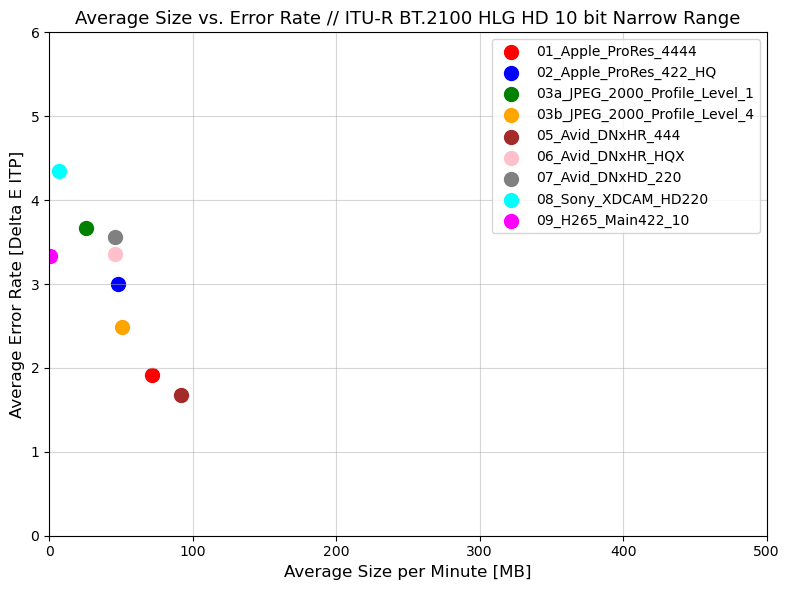

In [69]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt

def plot_csv_data(root_directory):
    # Initialize lists to store data for plotting
    x_values = []
    y_values = []
    file_names = []

    # Walk through all directories and subdirectories
    for dirpath, dirnames, filenames in os.walk(root_directory):
        for csv_file in filenames:
            if csv_file.endswith('.csv') and csv_file[:2].isdigit():
                csv_path = os.path.join(dirpath, csv_file)
                print(csv_path)

                # Read CSV file into a DataFrame, converting non-numeric values to NaN
                df = pd.read_csv(csv_path, header=None, error_bad_lines=False)

                # Extract values from the second row and first and second columns
                x_value = df.iloc[1, 0]
                y_value = df.iloc[1, 1]

                # Append values to the lists
                x_values.append(x_value)
                y_values.append(y_value)
                file_names.append(csv_file)

    # Convert x-axis values to float, divide by 5, and round to 4 digits
    x_values = (pd.to_numeric(x_values, errors='coerce') / 5 / 1000 / 1000).round(4)

    # Convert y-axis values to float with four digits after handling non-numeric values
    y_values = pd.to_numeric(y_values, errors='coerce').round(4)

    # Create a scatter plot
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    
    name_color_mapping = {'01_Apple_ProRes_4444': 'red', '02_Apple_ProRes_422_HQ': 'blue', '03a_JPEG_2000_Profile_Level_1': 'green', '03b_JPEG_2000_Profile_Level_4': 'orange', '04_Sony_XAVC-I_Class_300': 'purple',
                      '05_Avid_DNxHR_444': 'brown', '06_Avid_DNxHR_HQX': 'pink', '07_Avid_DNxHD_220': 'gray', '08_Sony_XDCAM_HD220': 'cyan', '09_H265_Main422_10': 'magenta'}


    ax.grid(True,alpha=0.5)
    ax.set_xlabel('Average Size per Minute [MB]',fontsize=12)
    ax.set_ylabel('Average Error Rate [P Det]',fontsize=12)
    ax.set_title('Average Size vs. Error Rate // ITU-R BT.2100 PQ HD 10 bit Full Range',fontsize=13)
    ax.set_xlim(0,500)
    ax.set_ylim(0,1)
    print(x_values)
    print(y_values)
    print(file_names)
    #ax.scatter(x_values, y_values,label=file_name,color=name_color_mapping[file_name], s=100)
    file_names = [name.rstrip('.csv') for name in file_names]


    file_names1 = sorted(file_names, key=lambda x: int(re.search(r'^(\d+)', x).group(1)))

    ax.grid(True, alpha=0.5)
    ax.set_xlabel('Average Size per Minute [MB]', fontsize=12)
    ax.set_ylabel('Average Error Rate [Delta E ITP]', fontsize=12)
    ax.set_title('Average Size vs. Error Rate // ITU-R BT.2100 HLG HD 10 bit Narrow Range', fontsize=13)
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 6)

    sorted_x_values = [x_values[file_names.index(name)] for name in file_names1]
    sorted_y_values = [y_values[file_names.index(name)] for name in file_names1]

    # Annotate each point with the corresponding file name
    for name in file_names1:
        color = name_color_mapping[name]
        index = file_names1.index(name)
        ax.scatter(sorted_x_values[index], sorted_y_values[index], label=name, color=color,s=100)

    plt.tight_layout()
    ax.legend()


    # Show the plot or save it to a file
 
    fig.savefig('/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR/04.2_ARRI_Encounters_HLG_HD_NR_Scatter_Plot.tiff')

    plt.show()

# Specify the root directory containing subdirectories with CSV files
root_directory = '/Volumes/jm_HDD/jm_MA_V1/CONTENT/82_File_Sizes_and_Delta_E/04.2_ARRI_Encounters_HLG_HD_NR'

# Call the function to plot CSV data
plot_csv_data(root_directory)
